### Classification

In [1]:
import pandas as pd
import numpy as np
from dataset import CountryBasedSplit

### 1. Get output from clustering

In [2]:
df = pd.read_csv('../../output/outbreak_groups_v2.csv')
df = df[['disease', 'country', 'year', 'month', 'peak_group']]
df = df.rename(columns={'peak_group': 'label'})
df['date'] = pd.to_datetime(df['year'].astype('str') + '-' + df['month'].astype('str') + '-' + '1')
df['id'] = df['country'] + '_' +df['disease'] + '_' + df['month'].astype(str) + '_' + df['year'].astype(str)
#df.to_csv('../../data/model_inputs/outbreak_groups.csv')

Open feature dataset:

In [3]:
climdf = pd.read_csv('../../data/processed/climate_data_monthly.csv')
climdf = climdf.rename(columns={'ADM0_NAME': 'country'})
climdf = climdf.groupby(['country', 'month', 'year', 'measure']).mean('value').reset_index()
climdf['date'] = pd.to_datetime(climdf['year'].astype('str') + '-' + climdf['month'].astype('str') + '-' + '1')
#climdf = climdf.pivot(index=['country', 'year', 'month', 'date'], columns='measure', values='value')
#climdf = climdf.rename_axis(None, axis=1)
#climdf = climdf.reset_index()

Split into train/test/val:

In [4]:
# Split and prepare features
splitter = CountryBasedSplit(df, climdf, country_column='country', month_column='month')

# Process the splits to get train, validation, and test sets
window_size = 12  # Example window size
desired_features = ['DailyLST', 'CHIRPSPrecip']
label_column = 'label'

(train_features, train_labels, train_ids), (val_features, val_labels, val_ids), (test_features, test_labels, test_ids) = splitter.process_splits(window_size, desired_features, label_column)
# Print the shapes of the 3D arrays

/Users/natai/Projects/RBDML/code/model/dataset.py:83: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in self.data.groupby([self.id_column]):


In [5]:
print(f"Train 3D shape: {train_features.shape}")
print(f"Validation 3D shape: {val_features.shape}")
print(f"Test 3D shape: {test_features.shape}")

Train 3D shape: (842, 2, 12)
Validation 3D shape: (276, 2, 12)
Test 3D shape: (276, 2, 12)


Plot how breakdown looks:

In [18]:
plot_split_breakdown(train_ids[0], val_ids[0], test_ids[0])

ValueError: x must be a label or position

### 2. Classify

In [20]:
from sklearn.ensemble import RandomForestClassifier
from aeon.transformations.collection.feature_based import Catch22
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


# Create and fit the pipeline
pipe = make_pipeline(
    Catch22(replace_nans=True),
    RandomForestClassifier(random_state=42),
)

pipe.fit(train_features, train_labels)
# Make predictions like any other sklearn estimator
accuracy_score(pipe.predict(val_features), val_labels)

ValueError: Found array with dim 3. RandomForestClassifier expected <= 2.

In [8]:
from sklearn import metrics
from aeon.classification.feature_based import Catch22Classifier, FreshPRINCEClassifier


c22cls = Catch22Classifier()
c22cls.fit(train_features, np.array(train_labels))
c22_preds = c22cls.predict(val_features)
metrics.accuracy_score(val_labels, c22_preds)

0.8442028985507246

In [14]:
f = c22cls.predict(test_features)

NameError: name 'plt' is not defined

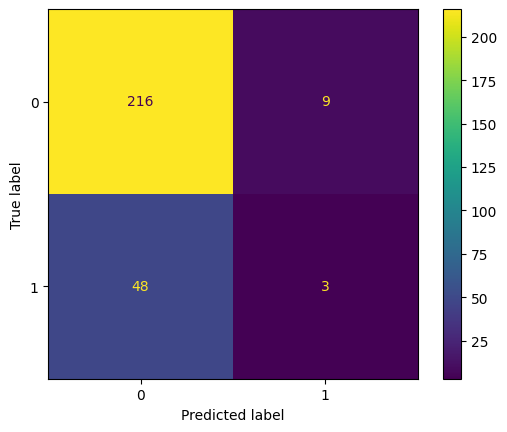

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels,f)

plt.show()

In [112]:
lag = 12
measures = ['DailyLST', 'CHIRPSPrecip', 'ModisEVI']
num_measures = len(measures)
climlist = []
labels = []
ids = []
clim_dfs = []

for id, d in df.groupby(['id']):
    start_date = d.date.item() - pd.tseries.offsets.MonthBegin(lag+1)
    end_date = d.date.item()
    clim_select = climdf[climdf['measure'].isin(measures)]
    # select country
    clim_select = clim_select[(clim_select.country == d.country.item())]
    clim_select = clim_select[(clim_select.date > start_date) & (clim_select.date < end_date)]
    pivot_df = np.array(clim_select.pivot_table(index='month', columns='measure', values='value'))
    if pivot_df.shape == (lag, num_measures):
        if not np.isnan(pivot_df).any():
            clim_dfs.append(clim_select)
            climlist.append(pivot_df)
            labels.append(d.label.item())
            ids.append(d.id.item())

/var/folders/6v/qv38gbln47510l23__b6mzyrvfzcd1/T/ipykernel_1112/2472605824.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for id, d in df.groupby(['id']):


In [113]:
a = np.dstack(climlist)
X = a.T.reshape(len(climlist), num_measures, lag)
y = np.array(labels)

In [114]:
from sklearn.model_selection import train_test_split
# split into train/test
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.33, random_state=72)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(940, 3, 12) (940,) (464, 3, 12) (464,)


In [53]:
from aeon.utils.validation import has_missing, is_equal_length, is_univariate
has_missing(X_test)
has_missing(X_train)

False

### 4. Train Classification Model

In [12]:
from sklearn import metrics

from aeon.classification.feature_based import Catch22Classifier, FreshPRINCEClassifier

from aeon.registry import all_estimators
from aeon.transformations.collection.feature_based import Catch22

In [75]:
from aeon.classification.convolution_based import RocketClassifier

rocket = RocketClassifier(num_kernels=2000)
rocket.fit(X_train, y_train)
y_pred = rocket.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
metrics.balanced_accuracy_score(y_test, y_pred)

0.6635753280661897

In [73]:
c22cls = Catch22Classifier()
c22cls.fit(X_train, y_train)
c22_preds = c22cls.predict(X_test)
metrics.accuracy_score(y_test, c22_preds)

0.8608695652173913

In [115]:
fp = FreshPRINCEClassifier()
fp.fit(X_train, y_train)
fp_preds = fp.predict(X_test)
metrics.accuracy_score(y_test, fp_preds)

0.9439655172413793

In [116]:
metrics.balanced_accuracy_score(y_test, fp_preds)

0.8622395833333334

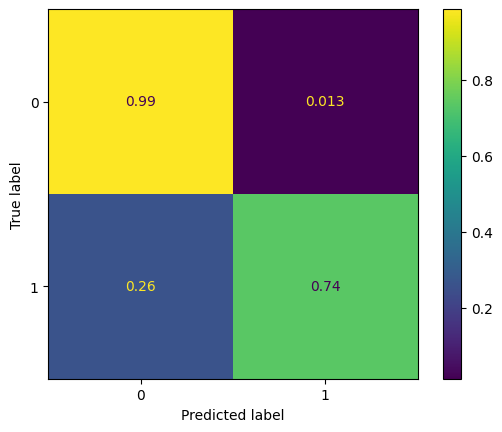

In [117]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, fp_preds, normalize='true')

plt.show()

Where is the model going wrong? 

In [31]:
outdf = pd.DataFrame({
    'test_labels': y_test,
    'pred_labels': fp_preds,
    'ids': ids_test
})

In [32]:
len(outdf)

589

In [33]:
outdf['match'] = outdf.test_labels + outdf.pred_labels


In [35]:
outdf[outdf]

,test_labels,pred_labels,ids,match
0,0,0,China_Hantavirus_4_2021,0
1,0,0,Nigeria_Lassa fever_10_2018,0
2,1,0,Slovenia_Hantavirus_4_2021,1
3,1,0,Germany_Hantavirus_1_2007,1
4,0,0,Finland_Hantavirus_4_2005,0
...,...,...,...,...
584,0,0,Brazil_Hantavirus_10_2007,0
585,0,0,Brazil_Hantavirus_5_2014,0
586,1,1,Austria_Hantavirus_3_2021,2
587,0,0,China_Hantavirus_5_2011,0
